In [1]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Fri Jul 17 17:28:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
#temporary until bug is fixed in current master
!git reset --hard 5ba1de0cdcc414c69ceb7a4c45eb1e3895eca32a
%cd /content

!pip install -r yolov5/requirements.txt  # install dependencies
%cd yolov5

import torch
from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.5.1+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)


In [3]:
import os, glob
import random

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
# !ls /mydrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
!mkdir training

In [6]:
# Copying dataset.yaml & model.yaml file from GDrive to Yolo training Folder
os.system(f"cp /mydrive/yolov5/dataset.yaml training")

os.system(f"cp /mydrive/yolov5/yolov5s.yaml training")

0

In [7]:
# put your own path here
dataset_path = '/mydrive/yolov5/dataset'

In [8]:
!mkdir training/data
!mkdir training/data/images
!mkdir training/data/labels
!mkdir training/data/images/train
!mkdir training/data/images/valid
!mkdir training/data/labels/train
!mkdir training/data/labels/valid

In [9]:
# Populate the folders
p = 20/100
for pathAndFilename in glob.iglob(os.path.join(dataset_path, "*.jpg")):
    title, ext = os.path.splitext(os.path.basename(pathAndFilename))
    if random.random() <=p :
      os.system(f"cp {dataset_path}/{title}.jpg training/data/images/valid")
      os.system(f"cp {dataset_path}/{title}.txt training/data/labels/valid")
    else:
      os.system(f"cp {dataset_path}/{title}.jpg training/data/images/train")
      os.system(f"cp {dataset_path}/{title}.txt training/data/labels/train")

In [10]:
!ls training

data  dataset.yaml  yolov5s.yaml


In [11]:
print(len(os.listdir('training/data/images/train')),' ', len(os.listdir('training/data/labels/train')))
print(len(os.listdir('training/data/images/valid')),' ', len(os.listdir('training/data/labels/valid')))

150   150
41   41


In [12]:
# Train yolov5s on custom dataset for 200 epochs
!python train.py --img 384 --batch 4 --epochs 200 --data training/dataset.yaml --cfg training/yolov5s.yaml --weights '' --name yolov5s_detect --cache --device 0

Apex recommended for faster mixed precision training: https://github.com/NVIDIA/apex
{'lr0': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'giou': 0.05, 'cls': 0.58, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.014, 'hsv_s': 0.68, 'hsv_v': 0.36, 'degrees': 0.0, 'translate': 0.0, 'scale': 0.5, 'shear': 0.0}
Your branch is behind 'origin/master' by 180 commits, and can be fast-forwarded.
  (use "git pull" to update your local branch)

Namespace(adam=False, batch_size=4, bucket='', cache_images=True, cfg='training/yolov5s.yaml', data='training/dataset.yaml', device='0', epochs=200, evolve=False, img_size=[384], multi_scale=False, name='yolov5s_detect', noautoanchor=False, nosave=False, notest=False, rect=False, resume=False, single_cls=False, weights='')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

2020-07-17 17:37:44.517165: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Succes

In [13]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

Output hidden; open in https://colab.research.google.com to view.

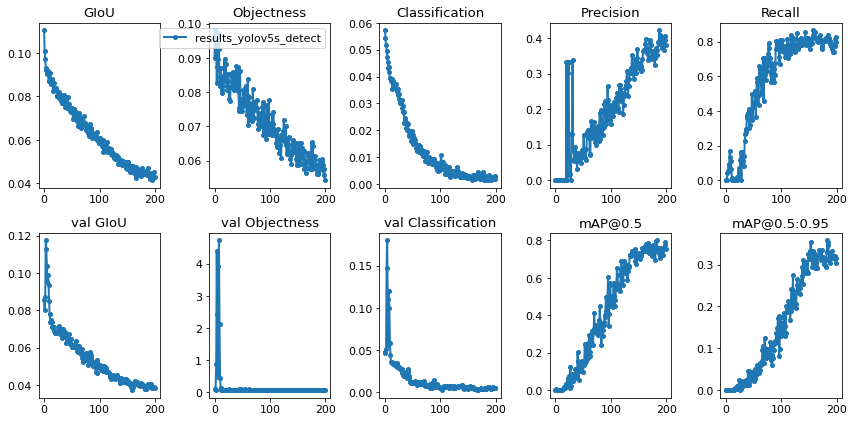

In [14]:
from utils.utils import plot_results
plot_results()

GROUND TRUTH TRAINING DATA:


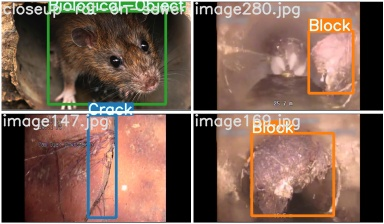

In [15]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='./test_batch0_gt.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


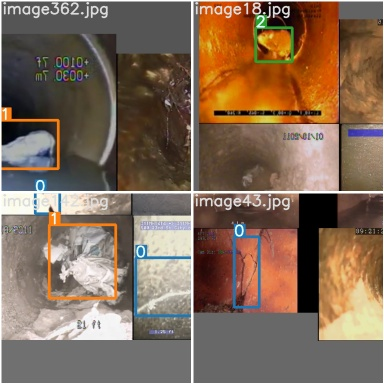

In [19]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='./train_batch2.jpg', width=900)

In [20]:
# Transfering some images from validation to inference folder
!find training/data/images/valid/ -maxdepth 1 -type f | head -5 | xargs cp -t "./inference/images/"

In [21]:
!python detect.py --weights weights/best_yolov5s_detect.pt --img 384 --conf 0.2 --source ./inference/images/

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.2, device='', img_size=384, iou_thres=0.5, output='inference/output', save_txt=False, source='./inference/images/', update=False, view_img=False, weights='weights/best_yolov5s_detect.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

image 1/7 inference/images/bus.jpg: 384x320 2 Blocks, Done. (0.012s)
image 2/7 inference/images/frame617.jpg: 320x384 Done. (0.009s)
image 3/7 inference/images/image181.jpg: 320x384 1 Cracks, Done. (0.009s)
image 4/7 inference/images/scene00571.jpg: 384x384 1 Cracks, 1 Biological-Objects, Done. (0.010s)
image 5/7 inference/images/scene142.jpg: 320x384 2 Cracks, 1 Blocks, 1 Biological-Objects, Done. (0.009s)
image 6/7 inference/images/see17.jpg: 320x384 1 Biological-Objects, Done. (0.009s)
image 7/7 inference/images/zidane.jpg: 256x384 Done. (0.009s)
Results saved to /content/yolov5/inference/output
Done. (0.203s)


In [22]:
import numpy as np
from pathlib import Path
import cv2
import torch
import torchvision
from IPython.display import display

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10
np.random.seed(42)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [23]:
def load_image(img_path: Path, resize=True):
  img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (128, 256), interpolation = cv2.INTER_AREA)
  return img
  
def show_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

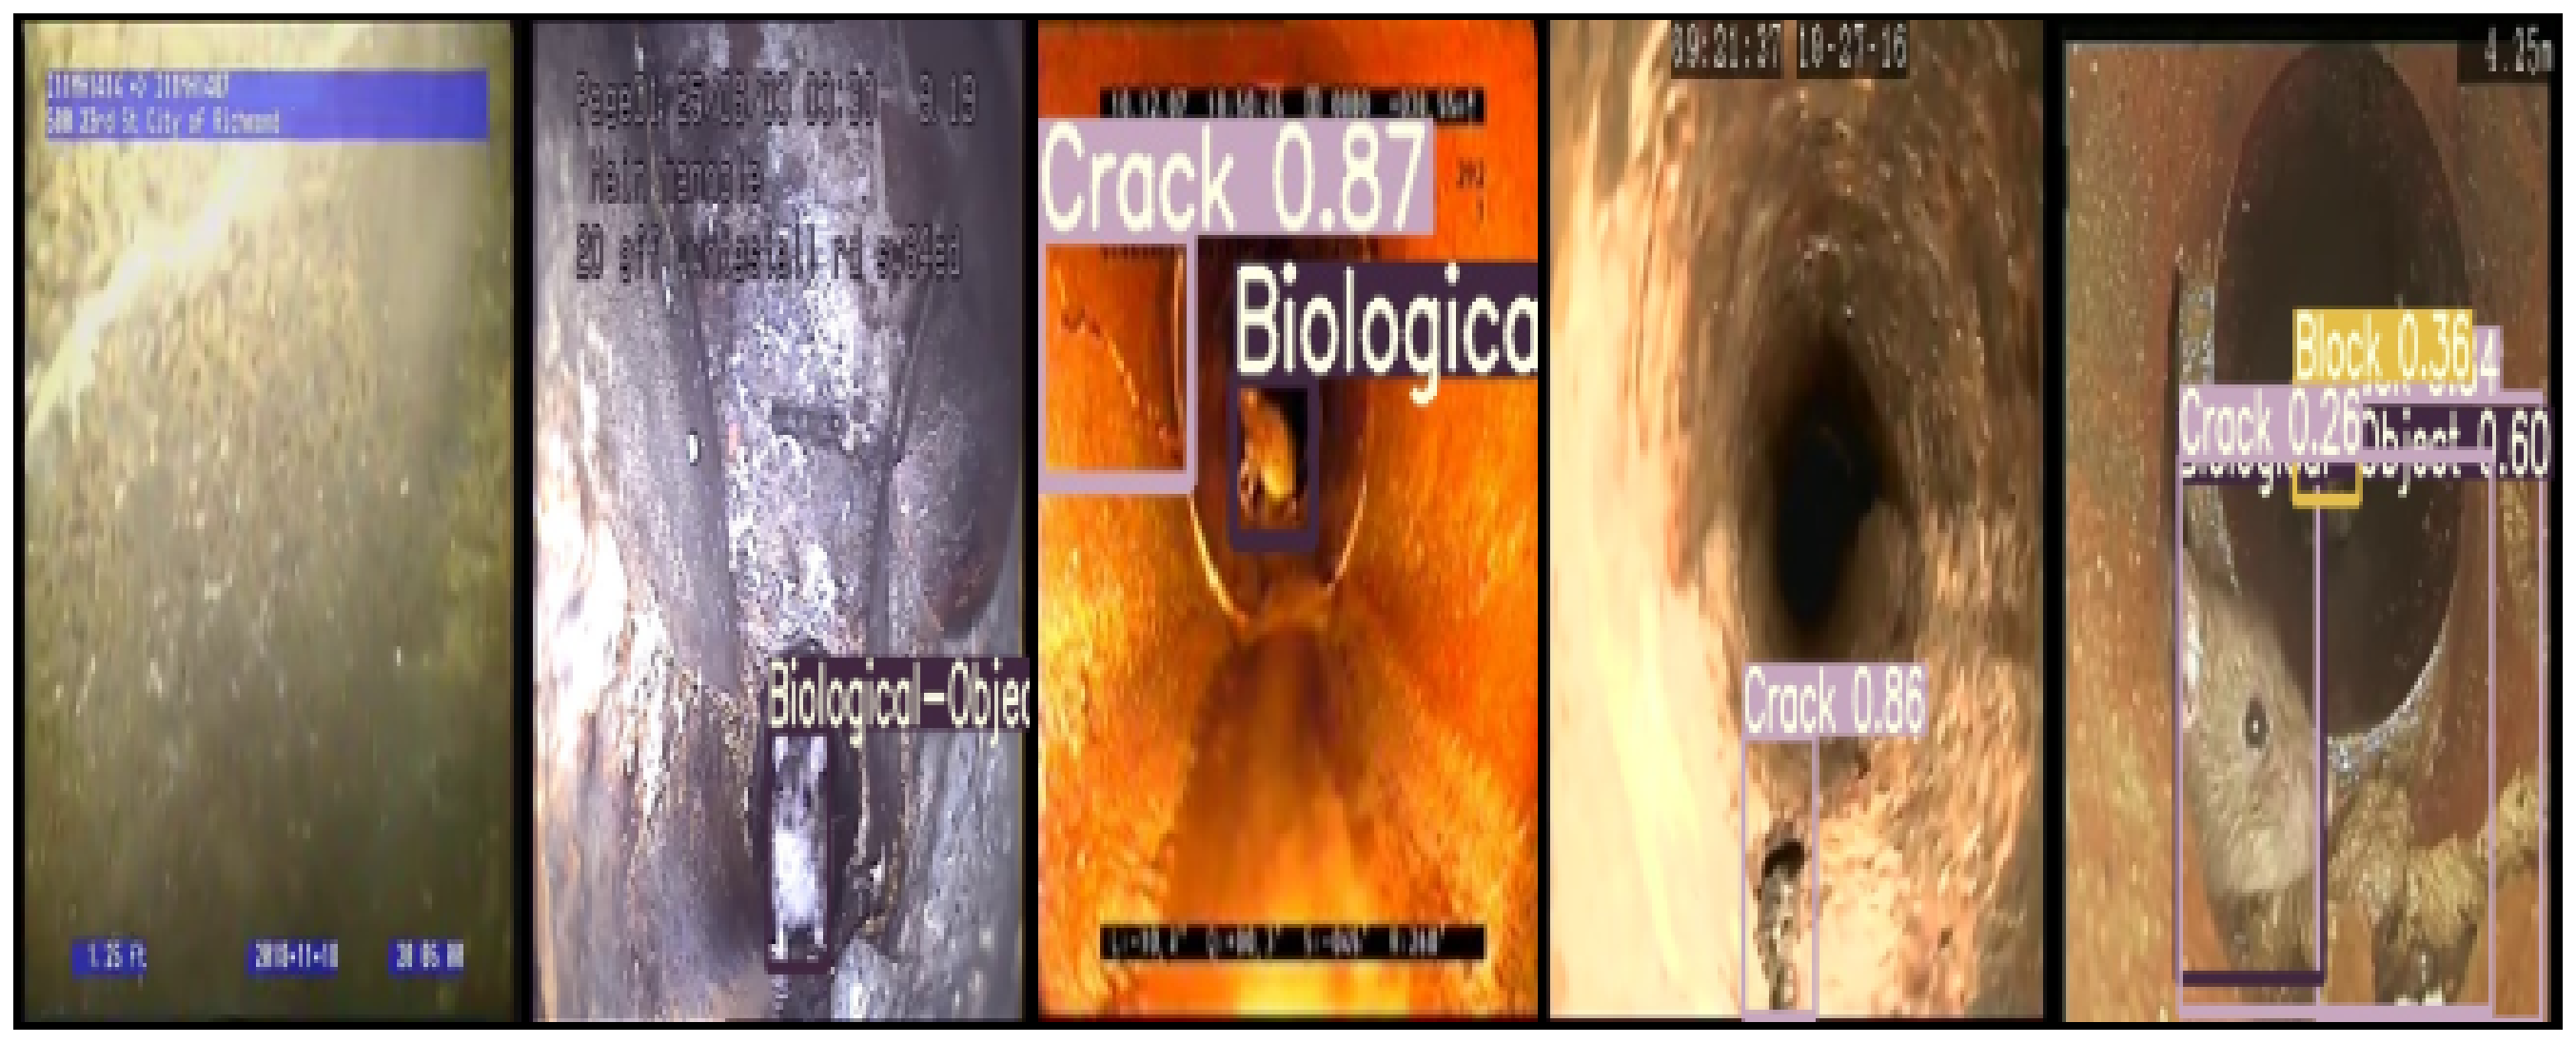

In [25]:
img_paths = list(Path("inference/output").glob("*.jpg"))[:22]
show_grid(img_paths)

In [26]:
# Copying mp4 file from GDrive to Yolo inference Folder
!mkdir inference/video
os.system(f"cp /mydrive/yolov5/block.mp4 inference/video")

0

In [27]:
!python detect.py --weights weights/best_yolov5s_detect.pt --source inference/video/block.mp4 --output inference/video_output

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', img_size=640, iou_thres=0.5, output='inference/video_output', save_txt=False, source='inference/video/block.mp4', update=False, view_img=False, weights='weights/best_yolov5s_detect.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

video 1/1 (1/4368) inference/video/block.mp4: 384x640 Done. (0.010s)
video 1/1 (2/4368) inference/video/block.mp4: 384x640 Done. (0.009s)
video 1/1 (3/4368) inference/video/block.mp4: 384x640 Done. (0.009s)
video 1/1 (4/4368) inference/video/block.mp4: 384x640 Done. (0.008s)
video 1/1 (5/4368) inference/video/block.mp4: 384x640 Done. (0.008s)
video 1/1 (6/4368) inference/video/block.mp4: 384x640 1 Blocks, Done. (0.009s)
video 1/1 (7/4368) inference/video/block.mp4: 384x640 1 Blocks, Done. (0.009s)
video 1/1 (8/4368) inference/video/block.mp4: 384x640 Done. (0.008s)
video 1/1 (9/4368) inference/video/block.mp4: 384x640 Done. (0.008s)
video 